#### Based on https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa
https://github.com/aniruddhachoudhury/BERT-Tutorials/blob/master/Blog%202/BERT_Fine_Tuning_Sentence_Classification.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import torch
import torch.nn as nn
from keras import utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients

In [3]:
model_base = 'neuralmind/bert-base-portuguese-cased'
model_path ='../../../models/virtual-operator/bert-base-portuguese-tapt-classifier/base-dataset-virtual-operator-virtual-operator-100-epochs-early-stop-reset-now-wandb'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# load model
model = BertForSequenceClassification.from_pretrained(model_path, output_attentions = False,
        output_hidden_states = False, num_labels=121)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_base)

In [4]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [5]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]
    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


In [6]:
def predict(inputs, token_type_ids, attention_mask):
    return model(inputs, attention_mask, token_type_ids)[0]

def custom_forward(inputs, token_type_ids, attention_mask, label):
    preds = predict(inputs, token_type_ids, attention_mask)
    return torch.softmax(preds, dim = 1)[:, label]

def save_act(module, inp, out):
    return saved_act

hook = model.bert.embeddings.register_forward_hook(save_act)
hook.remove()

In [7]:
def process(text, label):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
   

    lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)
    
    attributions_main, delta_main = lig.attribute(inputs=input_ids,
                                                  baselines=ref_input_ids,
                                                  n_steps = 150,
                                                  additional_forward_args=(token_type_ids, attention_mask, label),
                                                  return_convergence_delta=True)
    
    score = predict(input_ids, token_type_ids, attention_mask)
    attributions_main = attributions_main.cpu()
    delta_main = delta_main.cpu()
    score = score.cpu()
    prd_label = torch.argmax(torch.softmax(score, dim = 1)[0])
    
    #inv_label = 101
    #if(prd_label == inv_label or label == inv_label):
    r_df = add_attributions_to_visualizer(attributions_main, delta_main, text, score, label, all_tokens)
    return r_df
    
def add_attributions_to_visualizer(attributions, delta, text, score, label, all_tokens):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu()
    pred_class = torch.argmax(torch.softmax(score, dim = 1)[0])
    pred_score = torch.softmax(score, dim = 1)[0][pred_class]
    
    if(label == pred_class):
        l = 'Correct'
    else:
        l = 'Incorrect'
        
    df = pd.DataFrame({"result":l, "score":pred_score.item(), "attribution_score":attributions.sum().item()}, index=[0])
    score_vis.append(
        viz.VisualizationDataRecord(
            attributions,
            pred_score,
            pred_class,
            label,
            text,
            attributions.sum(),
            all_tokens,
            delta
        )
    )
    return df

In [8]:
def read_data(filename):
    data = pd.read_csv(filename, sep=";", names =['utterance','label'], header=None, dtype={'utterance':str, 'label': str} )
    return data

In [9]:
DATA_PATH = '../../../data/virtual-operator'
TEST_DATASET  = os.path.join(DATA_PATH, 'test.csv')

In [10]:
test_dataset = read_data(TEST_DATASET).dropna()

In [11]:
train_corpus = NLPDataset('virtual-operator', "train", 30, model_base)
test_corpus = NLPDataset('virtual-operator', "test", 30, model_base)
labels_dict = train_corpus.labels_dict

In [12]:
score_vis = []
results_df = pd.DataFrame() 
for step,row in tqdm_notebook(test_corpus.df.iterrows(), total=test_corpus.df.shape[0]):
#    if step == 50:
#        break
    text = row['utterance']
    label = train_corpus.labels_dict.get(row['label'])
    if label == 115:
        df = process(text, label)
        results_df = results_df.append(df, ignore_index=True)

Text(0.5, 0.98, 'Sintomas.Genérico.Promessa de oferta')

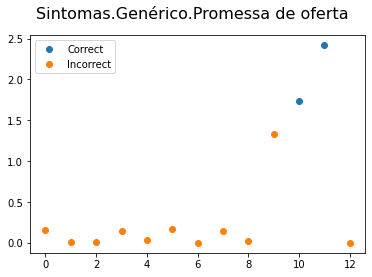

In [13]:
import matplotlib.pyplot as plt

groups = results_df.groupby("result")
for name, group in groups:
    plt.plot(group["attribution_score"],  marker="o", linestyle="", label=name)
plt.legend()
plt.suptitle('Sintomas.Genérico.Promessa de oferta', fontsize=16)

In [14]:
viz.visualize_text(score_vis)

In [15]:
score_vis = []
results_df = pd.DataFrame() 
for step,row in tqdm_notebook(test_corpus.df.iterrows(), total=test_corpus.df.shape[0]):
#    if step == 50:
#        break
    text = row['utterance']
    label = train_corpus.labels_dict.get(row['label'])
    if label == 108:
        df = process(text, label)
        results_df = results_df.append(df, ignore_index=True)

Text(0.5, 0.98, 'Sintomas.Qualificado.Cliente está longe')

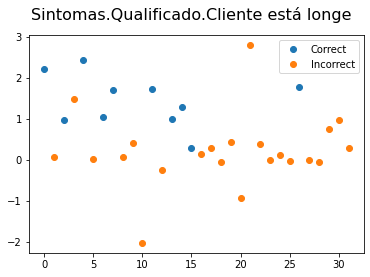

In [16]:
groups = results_df.groupby("result")
for name, group in groups:
    plt.plot(group["attribution_score"],  marker="o", linestyle="", label=name)
plt.legend()
plt.suptitle('Sintomas.Qualificado.Cliente está longe', fontsize=16)

In [17]:
viz.visualize_text(score_vis)

In [18]:
score_vis = []
results_df = pd.DataFrame() 
for step,row in tqdm_notebook(test_corpus.df.iterrows(), total=test_corpus.df.shape[0]):
#    if step == 50:
#        break
    text = row['utterance']
    label = train_corpus.labels_dict.get(row['label'])
    if label == 116:
        df = process(text, label)
        results_df = results_df.append(df, ignore_index=True)

Text(0.5, 0.98, 'Sintomas.Qualificado.Ausência sinal geral')

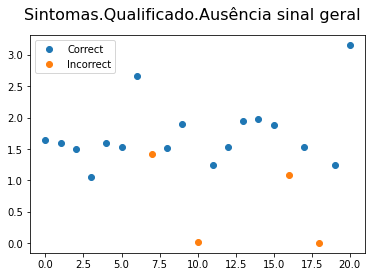

In [19]:
groups = results_df.groupby("result")
for name, group in groups:
    plt.plot(group["attribution_score"],  marker="o", linestyle="", label=name)
plt.legend()
plt.suptitle('Sintomas.Qualificado.Ausência sinal geral', fontsize=16)

In [20]:
viz.visualize_text(score_vis)

In [21]:
print(list(labels_dict.keys())[list(labels_dict.values()).index(108)])

Sintomas.Qualificado.Cliente está longe


In [22]:
print(labels_dict.get('Sintomas.Genérico.Falar com atendente'))

13
